# Classification multi classe

L'objectif de cette partie est, en se basant sur le travail précedement effectué, de proposer une évolution qui serait capable de différencier plusieurs types d'algorithmes.

In [39]:
#Libaries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import  Input, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.utils.vis_utils import plot_model
from random import shuffle

from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, accuracy_score

from PIL import Image, ImageDraw
import cv2

Nous allons réutiliser le même jeu de données que celui utilisé précédement, mais avec une classe neutre en plus. Les tailles des images étant peu adapté (40x40), il faut transformer celle ci dans une taille plus adequat, comme 48x48. Pour ce faire on ajoute juste des pixel noir autour de la figure en prenant en compte où est le sol.

On ajoute ensuite des pixels de manières égales des deux cotés de l'image mais également de chaque côté pour créer une sorte de translation des formes présentes sur l'image et ainsi encore un peu augmenter le jeu de données.

In [19]:
bdd_dir = os.listdir('bdd')
for path in bdd_dir:
    images = os.listdir(os.path.join('bdd', path))
    for img in images:
        img_path: str = os.path.join(os.path.join('bdd', path), img)
        img_type: str = os.path.splitext(img)[0][-1]
        image = Image.open(img_path)
        if img_type == 'f':
            bigger = image.crop((-4, 0, 44, 48))
            temp1 = image.crop((0,0,48,48))
            temp2 = image.crop((-8,0,40,48))
        elif img_type == 'D':
            bigger = image.crop((-8, -4, 40, 44))
            temp1 = image.crop((-8,-8,40,40))
            temp2 = image.crop((-8,0,40,48))
        elif img_type == 'G':
            bigger = image.crop((0, -4, 48, 44))
            temp1 = image.crop((0,0,48,48))
            temp2 = image.crop((0,-8,48,40))
        elif img_type == 'I':
            bigger = image.crop((-4, -8, 44, 40))
            temp1 = image.crop((0,-8,48,40))
            temp2 = image.crop((-8,-8,40,40))
        # Saving original image with new size
        bigger.save('bdd/' + path + '/' + img)
        # Saving new image
        temp1.save('bdd/' + path + '/' + img[:-4] + '_rs.bmp')
        temp2.save('bdd/' + path + '/' + img[:-4] + '_ls.bmp')

Ensuite on charge les images et on créé les jeux d'entrainements, de validation et de test.  Comme on traite un cas de classification multi classe, on applique du "one hot encoding" sur les données de sortie pour qu'elles soient formaté de manière standardisé. La fonction ci dessous prend donc en entrée des données quelconques et donne en sortie 3 jeu de données distincts: un jeu d'entrainement, un jeu de validation et un jeu de test.

In [2]:
def create_sets(data: list):
    """ Method that create train and test sets """
    train_index: int = round(len(data)*0.8)
    test_index: int = round(len(data)*0.9)
    train: list = data[:train_index]
    validation: list = data[train_index: test_index]
    test: list = data[test_index:]

    train_x = [i[0] for i in train]
    train_x = np.array(train_x)/255
    train_y = [i[1] for i in train]
                            
    val_x = [i[0] for i in validation]
    val_x = np.array(val_x)/255
    val_y = [i[1] for i in validation]                      

    test_x = [i[0] for i in test]
    test_x = np.array(test_x)/255
    test_y = [i[1] for i in test]

    return train_x, train_y, val_x, val_y, test_x, test_y

On applique ensuite cette fonction sur notre jeu de données:

In [3]:
# Getting paths
bdd_dir = os.listdir('bdd')
data: list = [] # Data array
# Load images for each path
for p in bdd_dir:
    path = os.path.join('bdd',p)
    images: list = os.listdir(path)
    for img in images:
        im = cv2.imread(os.path.join(path, img),cv2.IMREAD_GRAYSCALE)
        if p == "TBSR":
            data.append([im, np.array([1,0,0])])
        elif p == "C2SR":
            data.append([im, np.array([0,0,1])])
        elif p == "NEUTRE":
            data.append([im, np.array([0,1,0])])
# Shuffle the data to add randomness
shuffle(data)
# Create the different sets
train_x, train_y, val_x, val_y, test_x, test_y = create_sets(data)

# TODO: Review, incomplete, is it necessary ?

On définit ici une fonction loss personnalisée qui convient au problème que l'on résoud.

On considère trois classes: TBSR, Neutre et C2SR.

Cette fonction va déterminer si l'erreur du réseau est grande ou petite, et on peut les classifier de la manière suivante:
- Très grave: TBSR à la place de C2SR et vis versa
- Grave: neutre à la place de C2SR/TBSR
- Pas impactante: TBSR/C2SR à la place de neutre

Notre fonction loss va donc devoir plus ou moins pénalisés en fonction du type d'erreur. Comme les données en entrée sont "one hot encoded", le réseau va donner en sortie un vecteur de probabilité correspondant à la probabilité d'appartenance à chaque classe. 

In [4]:
def custom_loss(y_true, y_pred):
    """ Method that compute the custom algorithms classification loss """
    # Firstly, computing penalty coefficient for each y_true
    y_pred_penalties = []
    print(y_true)
    for i in range(len(y_true)):
        penalty = np.zeros(len(y_true), dtype='float')
        correct_index: int = y_true[i].index(1)
        predicted_index: int = y_pred.index(max(y_pred[i]))
        # If the error is big, we put a big penalty
        if (predicted_index == correct_index + 2) or (predicted_index == correct_index - 2):
            penalty[predicted_index] = 0.2
        # If the error is small, we put a not too big penalty
        if (predicted_index == correct_index + 1) or (predicted_index == correct_index - 1):
            penalty[predicted_index] = 0.6
        if(correct_index == predicted_index):
            penalty[predicted_index] = 1.2
            penalty = [0.2 if p != correct_index else 0 for p in range(len(penalty))]
        y_pred_penalties.append(penalty)
    return y_pred * np.array(y_pred_penalties)

Avant de passer à l'entrainement du modèle, on implémente une fonction se basant sur la classe LearningRateScheduler de Keras, ce qui va nous permettre d'ajuster le learning rate durant l'entrainement afin d'éviter un sur ou sous apprentissage:

In [6]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    """ Method that create a wrapper for LearningRateScheduler with step decay schedule"""
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))

    return LearningRateScheduler(schedule)

## Création du modèle

### Test modèle 1

Ici on reprend simplement le modèle de classification binaire en changeant le nombre de neurones de sorties pour en faire une modèle multi classe. On utilise aussi la fonction loss 'categorical_crossentropy' au lieu de la 'binary_crossentropy'. On remarque sur les courbes ci-dessous que les résultats sont bon mais que la loss est très ératiques et tout de même assez hautes en fin d'entrainement.

In [49]:
def simple_model(nb_class: int, input_shape: tuple):
    """ Method defining a simple multi class convolutional classfication model """
    # Input layer
    inputs = Input(input_shape)
    # Model layers
    c1 = Conv2D(name='conv1', filters=10, kernel_size=(3,3), activation="relu")(inputs)
    a1 = AveragePooling2D()(c1)
    c2 = Conv2D(filters=16, kernel_size=(3,3), activation="relu")(a1)
    a2 = AveragePooling2D()(c2)
    f = Flatten()(a2)
    d1 = Dense(128, activation="relu")(f)
    d2 = Dense(64, activation="relu")(d1)
    # Output layer
    outputs = Dense(nb_class, activation="softmax")(d2)
    
    model = Model(inputs, outputs)

    return model

In [54]:
# Define model training settings
epochs: int = 100

# Define model
simple = simple_model(3, (48, 48, 1))

In [26]:
# Compiling simple model with categorical crossentropy loss
simple.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),
               metrics=['accuracy'])


# Train the model using the parameters defined earlier
history_simple_1 = simple.fit(np.array(train_x), np.array(train_y),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(np.array(val_x), np.array(val_y)),
                    )

Epoch 1/100
91/91 [==============================] - 2s 18ms/step - loss: 0.8421 - accuracy: 0.5579 - val_loss: 0.7765 - val_accuracy: 0.6143
Epoch 2/100
91/91 [==============================] - 1s 15ms/step - loss: 0.7463 - accuracy: 0.6095 - val_loss: 0.7280 - val_accuracy: 0.6088
Epoch 3/100
91/91 [==============================] - 1s 15ms/step - loss: 0.6988 - accuracy: 0.6181 - val_loss: 0.7003 - val_accuracy: 0.6171
Epoch 4/100
91/91 [==============================] - 1s 15ms/step - loss: 0.6569 - accuracy: 0.6315 - val_loss: 0.7017 - val_accuracy: 0.6116
Epoch 5/100
91/91 [==============================] - 1s 15ms/step - loss: 0.6221 - accuracy: 0.6552 - val_loss: 0.6415 - val_accuracy: 0.6694
Epoch 6/100
91/91 [==============================] - 1s 15ms/step - loss: 0.5802 - accuracy: 0.6923 - val_loss: 0.6007 - val_accuracy: 0.6942
Epoch 7/100
91/91 [==============================] - 1s 14ms/step - loss: 0.5485 - accuracy: 0.7095 - val_loss: 0.6067 - val_accuracy: 0.6749
Epoch 

91/91 [==============================] - 1s 15ms/step - loss: 0.0671 - accuracy: 0.9684 - val_loss: 0.6787 - val_accuracy: 0.8567
Epoch 59/100
91/91 [==============================] - 2s 23ms/step - loss: 0.0678 - accuracy: 0.9636 - val_loss: 0.7371 - val_accuracy: 0.8623
Epoch 60/100
91/91 [==============================] - 1s 15ms/step - loss: 0.0628 - accuracy: 0.9694 - val_loss: 0.6891 - val_accuracy: 0.8650
Epoch 61/100
91/91 [==============================] - 1s 14ms/step - loss: 0.0943 - accuracy: 0.9629 - val_loss: 0.7480 - val_accuracy: 0.8623
Epoch 62/100
91/91 [==============================] - 1s 14ms/step - loss: 0.1037 - accuracy: 0.9536 - val_loss: 0.6708 - val_accuracy: 0.8733
Epoch 63/100
91/91 [==============================] - 1s 15ms/step - loss: 0.0872 - accuracy: 0.9598 - val_loss: 0.5720 - val_accuracy: 0.8760
Epoch 64/100
91/91 [==============================] - 1s 15ms/step - loss: 0.0773 - accuracy: 0.9632 - val_loss: 0.6542 - val_accuracy: 0.8623
Epoch 65/100

Dernière étape, on trace les courbes pour chacune des metrics du modèle:

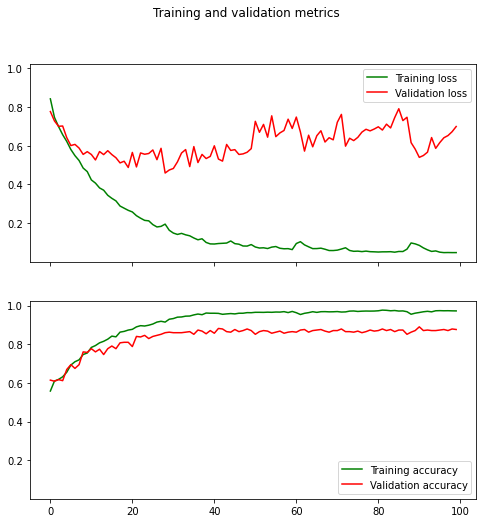

In [27]:
# Display 4 curves from history_simple (accuracy, loss, val_loss, val_accuracy)
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(8,8))
fig.suptitle('Training and validation metrics')
axs[0].plot(history_simple_1.epoch, history_simple_1.history['loss'], 'g', label='Training loss')
axs[0].plot(history_simple_1.epoch, history_simple_1.history['val_loss'], 'r', label='Validation loss')
axs[1].plot(history_simple_1.epoch, history_simple_1.history['accuracy'], 'g', label='Training accuracy')
axs[1].plot(history_simple_1.epoch, history_simple_1.history['val_accuracy'], 'r', label='Validation accuracy')
axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')
plt.show()

### Test Modèle 2: MaxPooling au lieu de AveragePooling

La modification ici consiste à remplacer les couches de AveragePooling par des couches de MaxPooling pour étudier l'impact de ce changement sur les performances du modèle. On remarque sur les courbes ci-dessous que la précision globale du modèle est plus haute et que la validation loss est un peu plus stable et est moins faible que celle du modèle précédent au cours de l'entrainement.

In [28]:
def simple_model2(nb_class: int, input_shape: tuple):
    """ Method defining a simple multi class convolutional classfication model """
    # Input layer
    inputs = Input(input_shape)
    # Model layers
    c1 = Conv2D(name='conv1', filters=10, kernel_size=(3,3), activation="relu")(inputs)
    a1 = MaxPooling2D()(c1)
    c2 = Conv2D(filters=16, kernel_size=(3,3), activation="relu")(a1)
    a2 = MaxPooling2D()(c2)
    f = Flatten()(a2)
    d1 = Dense(128, activation="relu")(f)
    d2 = Dense(64, activation="relu")(d1)
    # Output layer
    outputs = Dense(nb_class, activation="softmax")(d2)
    
    model = Model(inputs, outputs)

    return model

In [29]:
# Define model training settings
epochs: int = 100

# Define model
simple2 = simple_model2(3, (48, 48, 1))

In [30]:
# Compiling simple model with categorical crossentropy loss
simple1.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),
               metrics=['accuracy'])


# Train the model using the parameters defined earlier
history_simple_2 = simple1.fit(np.array(train_x), np.array(train_y),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(np.array(val_x), np.array(val_y)),
                    )

Epoch 1/100
91/91 [==============================] - 2s 19ms/step - loss: 0.8434 - accuracy: 0.5473 - val_loss: 0.7765 - val_accuracy: 0.5978
Epoch 2/100
91/91 [==============================] - 1s 16ms/step - loss: 0.7152 - accuracy: 0.6226 - val_loss: 0.6609 - val_accuracy: 0.6612
Epoch 3/100
91/91 [==============================] - 1s 16ms/step - loss: 0.5882 - accuracy: 0.6800 - val_loss: 0.5867 - val_accuracy: 0.7383
Epoch 4/100
91/91 [==============================] - 1s 16ms/step - loss: 0.4741 - accuracy: 0.7776 - val_loss: 0.4878 - val_accuracy: 0.7851
Epoch 5/100
91/91 [==============================] - 1s 16ms/step - loss: 0.3873 - accuracy: 0.8322 - val_loss: 0.3957 - val_accuracy: 0.8375
Epoch 6/100
91/91 [==============================] - 1s 15ms/step - loss: 0.3031 - accuracy: 0.8797 - val_loss: 0.3797 - val_accuracy: 0.8540
Epoch 7/100
91/91 [==============================] - 1s 16ms/step - loss: 0.2575 - accuracy: 0.8955 - val_loss: 0.3486 - val_accuracy: 0.8595
Epoch 

91/91 [==============================] - 1s 16ms/step - loss: 0.0384 - accuracy: 0.9749 - val_loss: 0.3681 - val_accuracy: 0.9063
Epoch 59/100
91/91 [==============================] - 1s 15ms/step - loss: 0.0393 - accuracy: 0.9752 - val_loss: 0.3532 - val_accuracy: 0.9091
Epoch 60/100
91/91 [==============================] - 1s 16ms/step - loss: 0.0382 - accuracy: 0.9770 - val_loss: 0.3480 - val_accuracy: 0.9091
Epoch 61/100
91/91 [==============================] - 2s 17ms/step - loss: 0.0413 - accuracy: 0.9742 - val_loss: 0.3493 - val_accuracy: 0.9008
Epoch 62/100
91/91 [==============================] - 2s 17ms/step - loss: 0.0376 - accuracy: 0.9770 - val_loss: 0.3633 - val_accuracy: 0.8981
Epoch 63/100
91/91 [==============================] - 1s 15ms/step - loss: 0.0361 - accuracy: 0.9766 - val_loss: 0.3674 - val_accuracy: 0.9091
Epoch 64/100
91/91 [==============================] - 1s 15ms/step - loss: 0.0367 - accuracy: 0.9766 - val_loss: 0.3680 - val_accuracy: 0.9091
Epoch 65/100

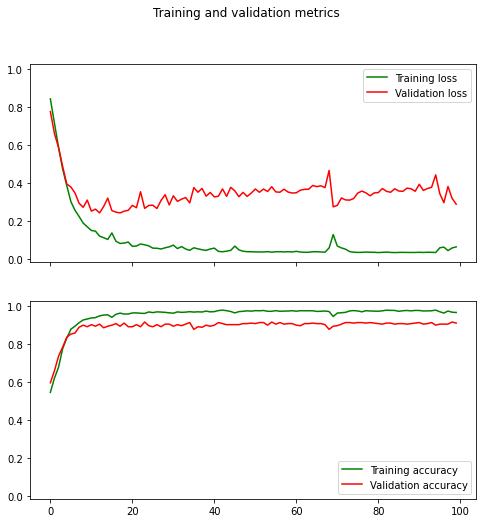

In [31]:
# Display 4 curves from history_simple (accuracy, loss, val_loss, val_accuracy)
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(8,8))
fig.suptitle('Training and validation metrics')
axs[0].plot(history_simple_2.epoch, history_simple_2.history['loss'], 'g', label='Training loss')
axs[0].plot(history_simple_2.epoch, history_simple_2.history['val_loss'], 'r', label='Validation loss')
axs[1].plot(history_simple_2.epoch, history_simple_2.history['accuracy'], 'g', label='Training accuracy')
axs[1].plot(history_simple_2.epoch, history_simple_2.history['val_accuracy'], 'r', label='Validation accuracy')
axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')
plt.show()

### Test Modèle 3: Using step_decay_schedule

Ici on ne va pas modifier le modèle en lui même mais utiliser notre fonction step_decay_schedule pour observer l'effet de son utilisation sur les performances du modèle. Pas d'amélioration du côté de la précision, mais la validation loss est bien plus basse et stable

In [38]:
def simple_model(nb_class: int, input_shape: tuple):
    """ Method defining a simple multi class convolutional classfication model """
    # Input layer
    inputs = Input(input_shape)
    # Model layers
    c1 = Conv2D(name='conv1', filters=8, kernel_size=(3,3), activation="relu")(inputs)
    a1 = MaxPooling2D()(c1)
    c2 = Conv2D(filters=16, kernel_size=(3,3), activation="relu")(a1)
    a2 = MaxPooling2D()(c2)
    f = Flatten()(a2)
    d1 = Dense(128, activation="relu")(f)
    d2 = Dense(64, activation="relu")(d1)
    # Output layer
    outputs = Dense(nb_class, activation="softmax")(d2)
    
    model = Model(inputs, outputs)

    return model

In [39]:
# Define model training settings
epochs: int = 100

# Define model
simple = simple_model(3, (48, 48, 1))

# Defining callbacks
callbacks = [step_decay_schedule(initial_lr=1e-3, decay_factor=0.1, step_size=10)]

In [40]:
# Compiling simple model with categorical crossentropy loss
simple.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),
               metrics=['accuracy'])


# Train the model using the parameters defined earlier
history_simple_3 = simple.fit(np.array(train_x), np.array(train_y),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(np.array(val_x), np.array(val_y)),
                    callbacks=callbacks)

Epoch 1/100
91/91 [==============================] - 2s 16ms/step - loss: 0.8669 - accuracy: 0.5139 - val_loss: 0.7921 - val_accuracy: 0.6006 - lr: 0.0010
Epoch 2/100
91/91 [==============================] - 1s 14ms/step - loss: 0.7386 - accuracy: 0.6085 - val_loss: 0.6893 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 3/100
91/91 [==============================] - 1s 14ms/step - loss: 0.6311 - accuracy: 0.6597 - val_loss: 0.5888 - val_accuracy: 0.6997 - lr: 0.0010
Epoch 4/100
91/91 [==============================] - 1s 14ms/step - loss: 0.5216 - accuracy: 0.7446 - val_loss: 0.4949 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 5/100
91/91 [==============================] - 1s 14ms/step - loss: 0.4348 - accuracy: 0.7879 - val_loss: 0.4157 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 6/100
91/91 [==============================] - 1s 14ms/step - loss: 0.3520 - accuracy: 0.8556 - val_loss: 0.3913 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 7/100
91/91 [==============================] - 1s 14ms/step - lo

91/91 [==============================] - 1s 15ms/step - loss: 0.0866 - accuracy: 0.9629 - val_loss: 0.2534 - val_accuracy: 0.9118 - lr: 1.0000e-08
Epoch 53/100
91/91 [==============================] - 1s 16ms/step - loss: 0.0866 - accuracy: 0.9629 - val_loss: 0.2534 - val_accuracy: 0.9118 - lr: 1.0000e-08
Epoch 54/100
91/91 [==============================] - 1s 16ms/step - loss: 0.0866 - accuracy: 0.9629 - val_loss: 0.2534 - val_accuracy: 0.9118 - lr: 1.0000e-08
Epoch 55/100
91/91 [==============================] - 2s 17ms/step - loss: 0.0866 - accuracy: 0.9629 - val_loss: 0.2534 - val_accuracy: 0.9118 - lr: 1.0000e-08
Epoch 56/100
91/91 [==============================] - 1s 16ms/step - loss: 0.0866 - accuracy: 0.9629 - val_loss: 0.2534 - val_accuracy: 0.9118 - lr: 1.0000e-08
Epoch 57/100
91/91 [==============================] - 2s 16ms/step - loss: 0.0866 - accuracy: 0.9629 - val_loss: 0.2534 - val_accuracy: 0.9118 - lr: 1.0000e-08
Epoch 58/100
91/91 [==============================] -

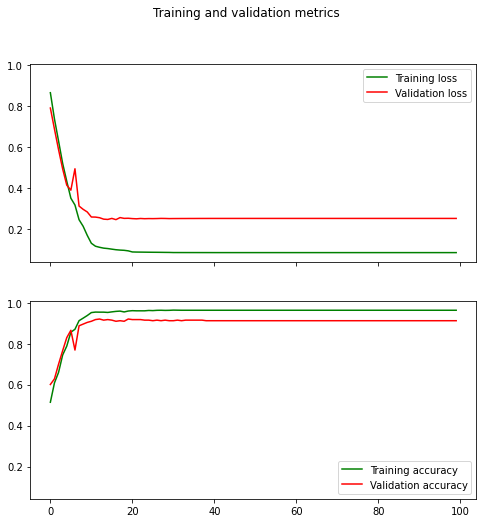

In [41]:
# Display 4 curves from history_simple (accuracy, loss, val_loss, val_accuracy)
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(8,8))
fig.suptitle('Training and validation metrics')
axs[0].plot(history_simple_3.epoch, history_simple_3.history['loss'], 'g', label='Training loss')
axs[0].plot(history_simple_3.epoch, history_simple_3.history['val_loss'], 'r', label='Validation loss')
axs[1].plot(history_simple_3.epoch, history_simple_3.history['accuracy'], 'g', label='Training accuracy')
axs[1].plot(history_simple_3.epoch, history_simple_3.history['val_accuracy'], 'r', label='Validation accuracy')
axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')
plt.show()

### Test modèle 4

Ce modèle, qui constitue donc le modèle final que l'on utilisera par la suite, comporte une troisième couche de convolution/maxpooling. Un système d'early stopping a été mis en place pour arrêter l'entrainement dès que le modèle ne s'améliore plus.

In [16]:
def simple_model4(nb_class: int, input_shape: tuple):
    """ Method defining a simple multi class convolutional classfication model """
    # Input layer
    inputs = Input(input_shape)
    # Model layers
    c1 = Conv2D(name='conv1', filters=8, kernel_size=(3,3), activation="relu")(inputs)
    a1 = MaxPooling2D()(c1)
    c2 = Conv2D(filters=16, kernel_size=(3,3), activation="relu")(a1)
    a2 = MaxPooling2D()(c2)
    c3 = Conv2D(filters=32, kernel_size=(3,3), activation="relu")(a2)
    a3 = MaxPooling2D()(c3)
    f = Flatten()(a3)
    d1 = Dense(128, activation="relu")(f)
    d2 = Dense(32, activation="relu")(d1)
    # Output layer
    outputs = Dense(nb_class, activation="softmax")(d2)
    
    model = Model(inputs, outputs)

    return model

In [17]:
# Define model training settings
epochs: int = 100

# Define model
simple4 = simple_model4(3, (48, 48, 1))

# Defining callbacks
callbacks = [step_decay_schedule(initial_lr=1e-3, decay_factor=0.3, step_size=10), EarlyStopping(patience=10)]

In [18]:
# Compiling simple model with categorical crossentropy loss
simple4.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),
               metrics=['accuracy'])

# Train the model using the parameters defined earlier
history_simple_4 = simple4.fit(np.array(train_x), np.array(train_y),
                    epochs=epochs,
                    verbose=1,
                    validation_data=(np.array(val_x), np.array(val_y)),
                    callbacks=callbacks)

Epoch 1/100
91/91 [==============================] - 2s 18ms/step - loss: 0.8616 - accuracy: 0.5452 - val_loss: 0.8233 - val_accuracy: 0.5978 - lr: 0.0010
Epoch 2/100
91/91 [==============================] - 1s 15ms/step - loss: 0.7774 - accuracy: 0.6071 - val_loss: 0.7907 - val_accuracy: 0.6006 - lr: 0.0010
Epoch 3/100
91/91 [==============================] - 1s 15ms/step - loss: 0.6992 - accuracy: 0.6518 - val_loss: 0.6724 - val_accuracy: 0.6364 - lr: 0.0010
Epoch 4/100
91/91 [==============================] - 1s 15ms/step - loss: 0.5803 - accuracy: 0.7075 - val_loss: 0.5594 - val_accuracy: 0.7548 - lr: 0.0010
Epoch 5/100
91/91 [==============================] - 2s 17ms/step - loss: 0.4707 - accuracy: 0.7869 - val_loss: 0.4791 - val_accuracy: 0.7686 - lr: 0.0010
Epoch 6/100
91/91 [==============================] - 2s 17ms/step - loss: 0.4112 - accuracy: 0.8171 - val_loss: 0.3866 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 7/100
91/91 [==============================] - 2s 19ms/step - lo

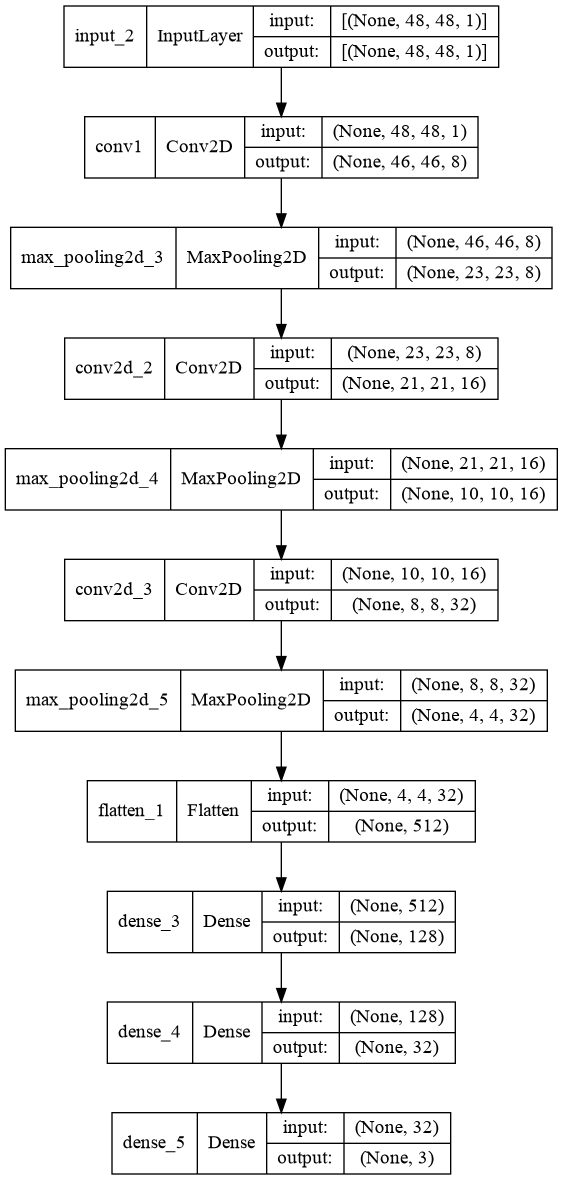

In [9]:
plot_model(simple4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

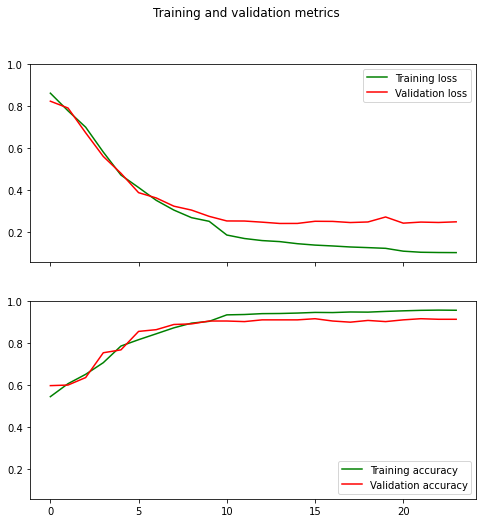

In [19]:
# Display 4 curves from history_simple (accuracy, loss, val_loss, val_accuracy)
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(8,8))
fig.suptitle('Training and validation metrics')
axs[0].plot(history_simple_4.epoch, history_simple_4.history['loss'], 'g', label='Training loss')
axs[0].plot(history_simple_4.epoch, history_simple_4.history['val_loss'], 'r', label='Validation loss')
axs[1].plot(history_simple_4.epoch, history_simple_4.history['accuracy'], 'g', label='Training accuracy')
axs[1].plot(history_simple_4.epoch, history_simple_4.history['val_accuracy'], 'r', label='Validation accuracy')
axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')
plt.show()

## Analyse des résultats

Comme évoqué juste avant, c'est le modèle 4 que l'on considère comme final et que l'on utilisera dans cette partie sur l'évaluation des résultats. Plusieurs étapes vont être nécessaire ici: premièrement le calcul de la précision et la matrice de confusion sur notre jeu de test. Mais ces mesures la ne sont pas réellement représentatives de notre cas d'études, car même si le probème dans sa globalité est un problème de classification, notre cas est un peu particulier. En effet, on rappel que la classe neutre signifie que les autres algorithmes (ici TBSR et C2SR, mais il pourrait y en avoir plus que deux autres) sont équivalent en terme de performance et que l'on peut choisir l'un ou l'autre. En d'autre terme, il faut recalculer la précision et la matrice de confusion du modèle en considérant comme juste également une classification de la classe TBSR ou C2SR vers la class Neutre.

Il nous faudra aussi déterminé le pourcentage d'erreur de classification pour chaque algorithme pour étudier une éventuelle convergence du modèle pour certain cas afin d'avoir des pistes d'améliorations pour le système. 

### Avant de commencer

 Pour faciliter la suite de ce travail, nous allons d'abord définir une fonction pour afficher une matrice de confusion.

In [ ]:
def extract_predictions(y_pred):
    """ Method that extract the final prediction"""

In [43]:
def display_confusion_matrix(y_pred, y_true):
    """ Method that display a confusion matrix """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [44]:
# Making a prediction
y_pred = simple4.predict(test_x)

### Calcul de base

Ici on va donc juste évaluer le modèle sans prendre en compte notre cas d'étude, simplement en l'évaluant comme un pur réseau de classification.

Accuracy: 90.66%


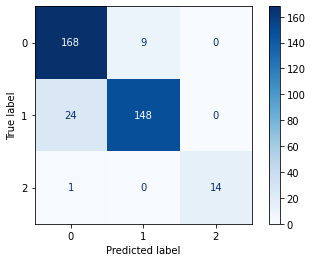

In [45]:
# Computing accuracy score
accuracy = accuracy_score(np.array(test_y).argmax(axis=1), [np.round(value) for value in y_pred.argmax(axis=1)])
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Display the confusion matrix
display_confusion_matrix(y_pred.argmax(axis=1), np.array(test_y).argmax(axis=1))

### Calcul amélioré

Pour cette partie, on va d'abord remplacer tous les cas NEUTRE vers TBSR/CS2R par une prédiction correspondants au neutre afin que les outils de base nous donne les bonnes données.

In [46]:
pred_label = y_pred.argmax(axis=1)
true_label = np.array(test_y).argmax(axis=1)
# For each prediction
for i in range(len(pred_label)):
    if true_label[i] == 1 and (pred_label[i] == 0 or pred_label[i] == 2):
        pred_label[i] = 1

Accuracy: 97.25%


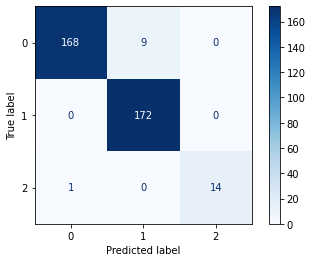

In [47]:
# Computing accuracy score
accuracy = accuracy_score(pred_label, true_label)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Display the confusion matrix
display_confusion_matrix(pred_label, true_label)

Pour finir on calcul le pourcentage d'erreurs graves et très graves

In [48]:
big_errors = 0 # case classified CS2R instead of TBSR, or reverse
errors = 0 # case classified NEUTRE instead of C2SR or TBSR
# For each prediction
for i in range(len(pred_label)):
    if (true_label[i] == 0 or true_label[i] == 2) and pred_label[i] == 1:
        errors += 1
    elif (true_label[i] == 0 and pred_label[i] == 2) or (true_label[i] == 2 and pred_label[i] == 0) :
        big_errors += 1
        
big_errors_percentage = big_errors/len(pred_label) * 100.0
errors_percentage = errors/len(pred_label) * 100.0
print("Big errors percentage", big_errors_percentage)
print("Errors percentage", errors_percentage)

Big errors percentage 0.27472527472527475
Errors percentage 2.4725274725274726
